In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv("../data/2021-10-19_14-11-08_val_candidate_data.csv")

In [3]:
data.head()

,Unnamed: 0,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,target
0,298,Female,No,0,Graduate,No,5000.0,2541,151.0,480.0,1.0,Rural,0,No,N
1,115,Male,Yes,1,Graduate,No,14583.0,0,185.0,180.0,1.0,Rural,1,No,Y
2,312,Female,No,0,Graduate,No,2507.0,0,56.0,360.0,1.0,Rural,0,No,Y
3,605,Male,Yes,0,Not Graduate,No,2400.0,3800,NaN,180.0,1.0,Urban,0,No,N
4,465,Male,No,0,Graduate,No,6000.0,0,140.0,360.0,1.0,Rural,0,No,Y


In [4]:
omitted_obs = []

### Quick peak at the data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  580 non-null    int64  
 1   feature_0   571 non-null    object 
 2   feature_1   577 non-null    object 
 3   feature_2   566 non-null    object 
 4   feature_3   562 non-null    object 
 5   feature_4   547 non-null    object 
 6   feature_5   563 non-null    float64
 7   feature_6   580 non-null    object 
 8   feature_7   559 non-null    float64
 9   feature_8   567 non-null    float64
 10  feature_9   533 non-null    float64
 11  feature_10  580 non-null    object 
 12  feature_11  566 non-null    object 
 13  feature_12  547 non-null    object 
 14  target      580 non-null    object 
dtypes: float64(4), int64(1), object(10)
memory usage: 68.1+ KB


##### Summary
- 580 total observations, with 13 features
- mix of numerical and categorical feature types
- most feature columns have some rows with missing values

### Peak at the categorical fields

In [6]:
cats = [
    "feature_0",
    "feature_1",
    "feature_2",
    "feature_3",
    "feature_4",
    "feature_6",
    "feature_10",
    "feature_11",
    "feature_12",
]

In [7]:
data.describe(include=object)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_6,feature_10,feature_11,feature_12,target
count,571,577,566,562,547,580,580,566,547,580
unique,2,2,4,2,2,259,3,4,2,2
top,Male,Yes,0,Graduate,No,0,Semiurban,0,No,Y
freq,465,380,324,440,475,259,225,324,475,397


In [8]:
for f in cats:
    print(f"feature: {f}")
    print(pd.crosstab(index=data[f], columns='freq'))
    print("\n")

feature: feature_0
col_0      freq
feature_0      
Female      106
Male        465


feature: feature_1
col_0      freq
feature_1      
No          197
Yes         380


feature: feature_2
col_0      freq
feature_2      
0           324
1            94
2            98
3+           50


feature: feature_3
col_0         freq
feature_3         
Graduate       440
Not Graduate   122


feature: feature_4
col_0      freq
feature_4      
No          475
Yes          72


feature: feature_6
col_0          freq
feature_6          
0               259
1.612.000.084     1
1000              1
1010              2
1014              1
...             ...
8333              1
9.857.999.878     1
913               1
923               1
997               1

[259 rows x 1 columns]


feature: feature_10
col_0       freq
feature_10      
Rural        162
Semiurban    225
Urban        193


feature: feature_11
col_0       freq
feature_11      
0            324
1             94
2             98
3+            

#### What's up with feature 6?
- it was read in as `object` type by pandas
- it appears its due to 2 records that have multiple "." in their entries
    - "9.857.999.878" and "1.612.000.084"

Couple options to go from here:
Since, I can't really make what this field is meant to represent, and I have no conviction as to how to fix these observations reliably, I can either:
1. omit these two records from the dataset;
2. treat them as missing and deal with them as I plan to deal with the other missing values in this column (which may be equivalent to action 1. above)

In [9]:
data['feature_6'][~data['feature_6'].apply(lambda x: '.' in x)].astype(int).describe()

count      578.000000
mean      1623.179931
std       2987.660904
min          0.000000
25%          0.000000
50%       1125.500000
75%       2269.500000
max      41667.000000
Name: feature_6, dtype: float64

In [10]:
data['feature_6'][~data['feature_6'].apply(lambda x: '.' in x)] # based on this these can all be cast into int type

0      2541
1         0
2         0
3      3800
4         0
       ... 
575    2336
576    1668
577    1041
578    1803
579     484
Name: feature_6, Length: 578, dtype: object

In [11]:
data[data['feature_6'].apply(lambda x: '.' in x)]

,Unnamed: 0,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,target
182,282,Male,Yes,2,Graduate,No,2301.0,9.857.999.878,78.0,180.0,1.0,Urban,2,No,Y
303,428,Male,Yes,0,Graduate,No,NaN,1.612.000.084,87.0,360.0,1.0,Rural,0,No,Y


In [12]:
# omit these, since I don't know the best way to handle imputation here
omitted_obs += [182, 303]

# df will be our DataFrame used for training
df = data.loc[~data.index.isin(omitted_obs)].reset_index(drop=True)
df['feature_6'] = df['feature_6'].astype(int)

# remove feature_6 as a cat feature
cats.remove('feature_6')

In [13]:
for f in cats:
    print(f"feature: {f}")
    print(pd.crosstab(index=df[f], columns='freq'))
    print("\n")

feature: feature_0
col_0      freq
feature_0      
Female      106
Male        463


feature: feature_1
col_0      freq
feature_1      
No          197
Yes         378


feature: feature_2
col_0      freq
feature_2      
0           323
1            94
2            97
3+           50


feature: feature_3
col_0         freq
feature_3         
Graduate       438
Not Graduate   122


feature: feature_4
col_0      freq
feature_4      
No          473
Yes          72


feature: feature_10
col_0       freq
feature_10      
Rural        161
Semiurban    225
Urban        192


feature: feature_11
col_0       freq
feature_11      
0            323
1             94
2             97
3+            50


feature: feature_12
col_0       freq
feature_12      
No           473
Yes           72




##### Summary
- `feature_6` was loaded in as an `object` type, but upon investigation it appears there were two inconsistent entries that lead to casting
    - all other entries for this column appear to be of int type for which there were 259 distinct values
    - while possible, unlikely this column is a categorical one with this many levels
    - going to treat this as a numeric type instead
- action taken was to omit these two observations from consideration in training the model
- with respect to the other features, the number of levels is less than or equal to 4, so we can nicely handle these with OHE if needed

### Peak at the numerical features

In [14]:
conts = [
    "feature_5",
    "feature_6",
    "feature_7",
    "feature_8",
    "feature_9"
]

In [15]:
df.describe()

,Unnamed: 0,feature_5,feature_6,feature_7,feature_8,feature_9
count,578.000000,562.000000,578.000000,557.000000,565.000000,531.000000
mean,304.089965,5534.281139,1623.179931,145.763016,343.178761,0.841808
std,177.053671,6512.091445,2987.660904,84.651579,64.050110,0.365265
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000
25%,150.250000,2890.250000,0.000000,100.000000,360.000000,1.000000
50%,306.500000,3815.000000,1125.500000,125.000000,360.000000,1.000000
75%,454.750000,5939.500000,2269.500000,166.000000,360.000000,1.000000
max,612.000000,81000.000000,41667.000000,650.000000,480.000000,1.000000


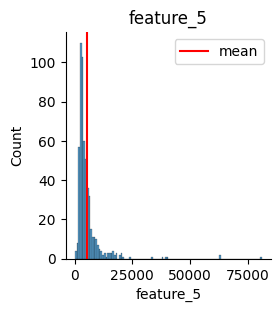

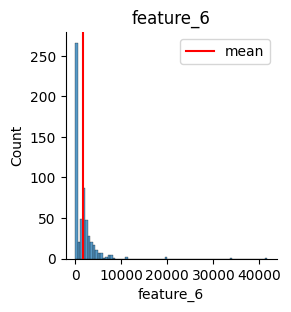

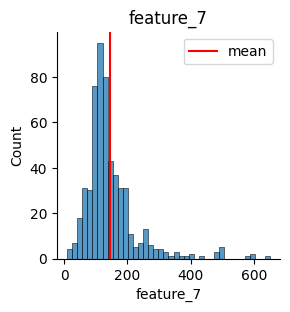

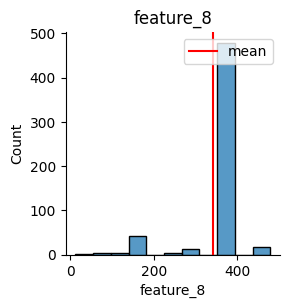

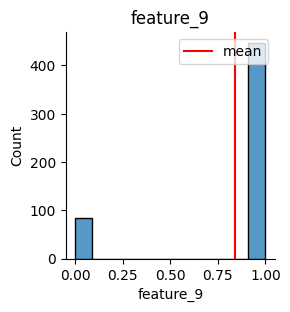

In [16]:
for f in conts:
    ax = sns.displot(df[f], kde=False, height=3)
    plt.axvline(x=np.mean(df[f]), color='red', label='mean')
    plt.legend(loc='upper right')
    plt.title(f"{f}")

#### What's up with `feature_8` and `feature_9`
- `feature_8` only takes on values that are multiples of 12, but importantly there are only 10 different levels. Though I would suspect this feature is an ordinal one.
- `feature_9` looks like it only takes on binary values
- probably should be treated as a categorical type
    - will go ahead and treat this as a categorical feature instead of a numerical one

In [17]:
pd.crosstab(index=df['feature_8'], columns='freq')

col_0,freq
feature_8,
12.0,1
36.0,1
60.0,2
84.0,2
120.0,3
180.0,43
240.0,4
300.0,13
360.0,479


In [18]:
pd.crosstab(index=df['feature_9'], columns='freq')

col_0,freq
feature_9,
0.0,84
1.0,447


In [19]:
cats.append('feature_8')
cats.append('feature_9')
conts.remove('feature_8')
conts.remove('feature_9')

### Rows with missing observations

- There are still a bunch of rows with some missing values
    - 150 rows to be precise (~25% of the dataset)

In [21]:
df.isna().any(axis=1).sum()

150

#### Summary
- Will need to do either:
    1. A Complete Case Analysis (removing all of the rows with missing values)
    2. Apply some sensible imputation methods
        - `categorical`: add `missing` category
        - `numerical`: use average

In [22]:
# complete case analysis
complete_df = df[~df.isna().any(axis=1)].reset_index(drop=True)
complete_df.shape

(428, 15)

In [23]:
imputed_df = df.copy()

In [24]:
# imputing categorical
for f in cats:
    imputed_df[f] = pd.Categorical(imputed_df[f].fillna('missing'))

In [25]:
# imputing numerical
for f in conts:
    mean = np.mean(imputed_df[f])
    imputed_df[f] = imputed_df[f].fillna(mean)

In [27]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  578 non-null    int64   
 1   feature_0   578 non-null    category
 2   feature_1   578 non-null    category
 3   feature_2   578 non-null    category
 4   feature_3   578 non-null    category
 5   feature_4   578 non-null    category
 6   feature_5   578 non-null    float64 
 7   feature_6   578 non-null    int64   
 8   feature_7   578 non-null    float64 
 9   feature_8   578 non-null    category
 10  feature_9   578 non-null    category
 11  feature_10  578 non-null    category
 12  feature_11  578 non-null    category
 13  feature_12  578 non-null    category
 14  target      578 non-null    object  
dtypes: category(10), float64(2), int64(2), object(1)
memory usage: 30.0+ KB


In [28]:
for f in cats:
    print(f"feature: {f}")
    print(pd.crosstab(index=imputed_df[f], columns='freq'))
    print("\n")

feature: feature_0
col_0      freq
feature_0      
Female      106
Male        463
missing       9


feature: feature_1
col_0      freq
feature_1      
No          197
Yes         378
missing       3


feature: feature_2
col_0      freq
feature_2      
0           323
1            94
2            97
3+           50
missing      14


feature: feature_3
col_0         freq
feature_3         
Graduate       438
Not Graduate   122
missing         18


feature: feature_4
col_0      freq
feature_4      
No          473
Yes          72
missing      33


feature: feature_10
col_0       freq
feature_10      
Rural        161
Semiurban    225
Urban        192


feature: feature_11
col_0       freq
feature_11      
0            323
1             94
2             97
3+            50
missing       14


feature: feature_12
col_0       freq
feature_12      
No           473
Yes           72
missing       33


feature: feature_8
col_0      freq
feature_8      
12.0          1
36.0          1
60.0      

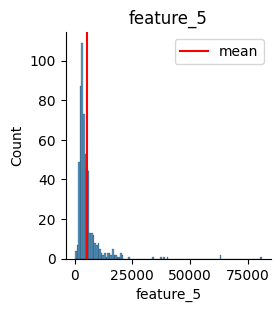

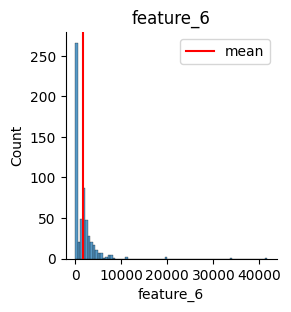

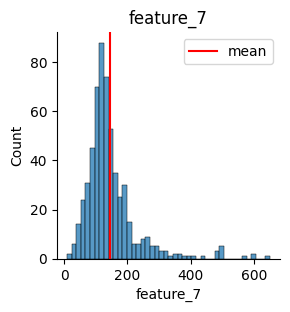

In [29]:
for f in conts:
    ax = sns.displot(imputed_df[f], kde=False, height=3)
    plt.axvline(x=np.mean(imputed_df[f]), color='red', label='mean')
    plt.legend(loc='upper right')
    plt.title(f"{f}")

### Target Variable

In [30]:
target = 'target'

In [32]:
print(pd.crosstab(index=imputed_df[target], columns='freq'))

col_0   freq
target      
N        183
Y        395


In [35]:
183 / (183 + 395)

0.3166089965397924

In [33]:
print(pd.crosstab(index=complete_df[target], columns='freq'))

col_0   freq
target      
N        134
Y        294


In [34]:
134 / (134 + 294)

0.3130841121495327

#### Summary
- Slight imbalance with target variable ~31% for both `complete_df` and `imputed_df` 
- Probably best to not rely on `accuracy` of ML model, but instead `f1_score`, `precision`, `recall` depending on the objective function of the downstream measurement 